This notebook covers the following topics for single object detection problem. we have used lite weight datasets to analyze this problem with minimal setup.

1. Data Analysis
2. Data Loading
3. Model Setup
4. Training
5. Visulisation

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as mpatches

In [ ]:

import zipfile

local_zip = 'datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('datasets')
zip_ref.close()

base_dir = 'datasets/'
flowers_dir = os.path.join(base_dir, '')

**Transforming row data to dataframe**

here the data format for annotations are quit unsual than people used to so better to first convert this in suitable format for smoother operations in training.

In [ ]:
# Define Directory
images_directory = "/content/datasets/datasets/images"
annotations_directory="/content/datasets/datasets/annotations"

img_paths = sorted([os.path.join(images_directory, fname) for fname in os.listdir(images_directory) if fname.endswith(".jpg")])
label_paths = sorted([os.path.join(annotations_directory, fname) for fname in os.listdir(annotations_directory) if fname.endswith(".xml")])

k = len(img_paths)

data_list = []

for i in range(k):
    annotation_file=label_paths[i]
    ds = BeautifulSoup(open(annotation_file).read(), "html.parser")

    # Iterating over each object elements
    for o in ds.find_all("object"):

        x_min = max(0, int(float(o.find("xmin").string)))
        y_min = max(0, int(float(o.find("ymin").string)))
        x_max = min(int(ds.find("width").string), int(float(o.find("xmax").string)))
        y_max = min(int(ds.find("height").string), int(float(o.find("ymax").string)))

        # in case the boundary goes above its limis, providing some restrictions.
        if x_min >= x_max or y_min >= y_max:
            continue
        elif x_max <= x_min or y_max <= y_min:
            continue

        sample = [str(img_paths[i]), x_min, y_min, x_max, y_max]

        data_list.append(sample)

data = pd.DataFrame(data_list)

**Visulisation**

let's visulise the data to see how it has been disctributed or balanced.

In [ ]:
data.head()

,0,1,2,3,4
0,/content/datasets/datasets/images/a (1).jpg,38,54,179,173
1,/content/datasets/datasets/images/a (10).jpg,58,14,155,117
2,/content/datasets/datasets/images/a (100).jpg,86,18,182,125
3,/content/datasets/datasets/images/a (101).jpg,23,16,120,115
4,/content/datasets/datasets/images/a (102).jpg,33,30,166,173


xmin 38 ymin 54 xmax 179 ymax 173


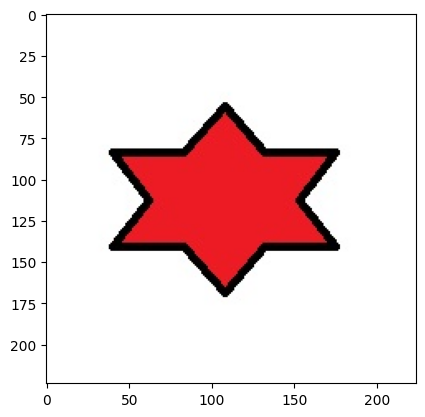

In [ ]:
img = plt.imread(data[0][0])
plt.imshow(img)
print('xmin', data[1][0], 'ymin',data[2][0],'xmax',data[3][0],'ymax',data[4][0])

In [ ]:
print(img.shape)

(224, 224, 3)


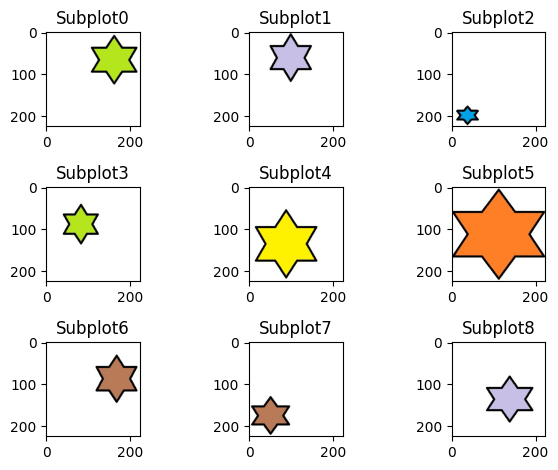

In [ ]:
width=5
height=5
rows = 3
cols = 3
axes=[]
fig=plt.figure()
for a in range(rows*cols):
    c = np.random.randint(100)
    img = plt.imread(data[0][c])
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)
    plt.imshow(img)
fig.tight_layout()
plt.show()

x_min samples

**2. Data Loading**

now its time to implemet efficeint data loading technic to boost the training time. tf.data seems the popular efficient approach for such task. applying it to our selected data.

In [ ]:
def proc_image(path, xmin, ymin, xmax, ymax):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float64)
    return image/255.0, (xmin, ymin, xmax, ymax)

**Training and Validation Split**

it is required to split data between training and validation to avoid overfitting in model training. for the case we have split data between 80-20 where 80 percentage data is used for training and remaining 20 percentage is used for the validation.

In [ ]:
np.random.seed(127)
bs = 16 #batch size
valid_mask = np.random.rand(len(data)) < 0.2
val = data[valid_mask]
train = data[~valid_mask]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train[0].values, train[1].values, train[2].values ,train[3].values, train[4].values))
dataset = dataset.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(241).cache().repeat().batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((val[0].values, val[1].values, val[2].values, val[3].values, val[4].values))
dataset_valid = dataset_valid.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(241).cache().batch(bs).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

steps_per_epoch_train = len(train) // bs
validation_steps = len(val) // bs

visulise data loader

**Model Setup**

lets create basic model for bounding box regression like problem with input size of 224x224 and output of 4 channel. the model is deigned with inceasing feature map size over each layer to improve the scope of detection. linear layer at end for fitting with bounding box number is producing quite amazing results for the regression case.

In [ ]:
# Model Setup
x0 = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2), activation=tf.nn.relu)(x0)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(6,6), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(7,7), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(8,8), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(9,9), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(10,10), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(15,15), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(20,20), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(25,25), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(30,30), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(40,40), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(45,45), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), activation=tf.nn.relu)(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)

x = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x)
x =tf.keras.layers.Dropout(0.2)(x)

x1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x1 =tf.keras.layers.Dropout(0.2)(x1)
y1 = tf.keras.layers.Dense(1, activation="linear")(x1)

x2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x2 =tf.keras.layers.Dropout(0.2)(x2)
y2 = tf.keras.layers.Dense(1, activation="linear")(x2)

x3 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x3 =tf.keras.layers.Dropout(0.2)(x3)
y3 = tf.keras.layers.Dense(1, activation="linear")(x3)

x4 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x4 =tf.keras.layers.Dropout(0.2)(x4)
y4 = tf.keras.layers.Dense(1, activation="linear")(x4)

model = tf.keras.Model(inputs=x0, outputs=[y1, y2, y3, y4])
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss=['mse','mse','mse','mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 223, 223, 64)         832       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 221, 221, 32)         18464     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 218, 218, 32)         16416     ['conv2d_1[0][0]']            
                                                                                              

**4. Training**

we have trained this model upto 100 epoch but it could be trainned further to improve the accuracy bit more. here we have used mean squre error criteria for evaluation and tarining as problem seems bit of regression.

In [ ]:
hist = model.fit(dataset,epochs = 50,steps_per_epoch=steps_per_epoch_train, validation_data=dataset_valid, validation_steps=validation_steps)

Epoch 1/50
5/5 [==============================] - 926s 187s/step - loss: 1413889.1250 - dense_2_loss: 198318.8594 - dense_4_loss: 179912.0156 - dense_6_loss: 368592.1562 - dense_8_loss: 667066.0625 - val_loss: 58746.7539 - val_dense_2_loss: 2143.4685 - val_dense_4_loss: 6134.6416 - val_dense_6_loss: 21541.0762 - val_dense_8_loss: 28927.5664
Epoch 2/50
5/5 [==============================] - 873s 177s/step - loss: 66935.3984 - dense_2_loss: 4148.2896 - dense_4_loss: 5972.1357 - dense_6_loss: 26305.0938 - dense_8_loss: 30509.8809 - val_loss: 68230.2188 - val_dense_2_loss: 2300.5154 - val_dense_4_loss: 7287.0913 - val_dense_6_loss: 23932.2344 - val_dense_8_loss: 34710.3750
Epoch 3/50
5/5 [==============================] - 864s 175s/step - loss: 69831.6562 - dense_2_loss: 4446.7261 - dense_4_loss: 5900.9985 - dense_6_loss: 27790.9180 - dense_8_loss: 31693.0195 - val_loss: 68219.0078 - val_dense_2_loss: 2298.4043 - val_dense_4_loss: 7286.5693 - val_dense_6_loss: 23927.0820 - val_dense_8_loss

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.grid(True)
plt.legend()

**5.Visulisation**

In [ ]:
path = "/content/datasets/datasets/images/a (1).jpg"
image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.cast(image, tf.float64)
image = image/255.0
res = model.predict(tf.expand_dims(image,0))

w = res[2] - res[0]
h = res[3] - res[1]
rect=mpatches.Rectangle((res[0],res[1]),w,h, fill = True,color = "purple",linewidth = 10)
print(res[0], res[1], res[2], res[3])
plt.imshow(image)
plt.gca().add_patch(rect)